In [ ]:
#yeah so the goal here is to experiment with the "up-down" network combining "up" and "down" amortised inference to see if this will be able to learn anything.
#Effectively I'm pretty sure it's perfrming backprop in two directions at once and then interfering with each other but would be a really cool conceptual idea 
#perhaps this is something the brain could be doing. But the interference problem -- I'm not sure how to resolve.
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import math

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_batches= 10
num_train_batches=20
batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def onehot(x):
    z = torch.zeros([len(x),10])
    for i in range(len(x)):
      z[i,x[i]] = 1
    return z.float().to(DEVICE)

# get some random training images
dataset = list(iter(trainloader))
for i,(img, label) in enumerate(dataset):
  dataset[i] = (img.reshape(len(img),784) /255 ,label)

images, labels = dataset[0]
# okay, now let's go through them all and manually reshape
print("IMAGES: ", images.shape)
print("LABELS: ", labels.shape)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


IMAGES:  torch.Size([64, 784])
LABELS:  torch.Size([64])


In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_tensor(xs):
  return xs.float().to(DEVICE)

def tanh(xs):
    return torch.tanh(xs)

def linear(x):
    return x

def tanh_deriv(xs):
    return 1.0 - torch.tanh(xs) ** 2.0

def linear_deriv(x):
    return set_tensor(torch.ones((1,)))

def relu(xs):
  return torch.clamp(xs,min=0)

def relu_deriv(xs):
  rel = relu(xs)
  rel[rel>0] = 1
  return rel 

def softmax(xs):
  return torch.nn.softmax(xs)

def sigmoid(xs):
  return F.sigmoid(xs)

def sigmoid_deriv(xs):
  return F.sigmoid(xs) * (torch.ones_like(xs) - F.sigmoid(xs))
   
def edge_zero_pad(img,d):
  N,C, h,w = img.shape 
  x = torch.zeros((N,C,h+(d*2),w+(d*2))).to(DEVICE)
  x[:,:,d:h+d,d:w+d] = img
  return x


def accuracy(out, L):
  B,l = out.shape
  total = 0
  for i in range(B):
    if torch.argmax(out[i,:]) == torch.argmax(L[i,:]):
      total +=1
  return total/ B

#DEVICE="cpu"

In [ ]:

class UpDownLayer(object):
  def __init__(self, input_size,output_size,batch_size, learning_rate,f,df,device="cpu"):
    self.input_size = input_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.f = f 
    self.df = df
    self.device = device
    self.upwards_weights = torch.empty([self.input_size,self.output_size]).normal_(mean=0.0,std=0.05).to(self.device)
    self.downwards_weights = torch.empty([self.output_size,self.input_size]).normal_(mean=0.0,std=0.05).to(self.device)

  def upward_predict(self,x):
    self.upward_inp = x.clone()
    self.upwards_activations = torch.matmul(self.upward_inp, self.upwards_weights)
    return self.f(self.upwards_activations)

  def downward_predict(self,x):
    self.downward_inp = x.clone()
    self.downwards_activations = torch.matmul(self.downward_inp, self.downwards_weights)
    return self.f(self.downwards_activations)

  def backward(self,e):
    self.fn_deriv = self.df(self.activations)
    out = torch.matmul(e * self.fn_deriv, self.weights.T)
    return torch.clamp(out,-50,50)

  def update_upwards_weights(self,e,update_weights=False):
    self.upwards_fn_deriv = self.df(self.upwards_activations)
    if update_weights:
      dw = torch.matmul(self.upward_inp.T, e * self.upwards_fn_deriv)
      self.upwards_weights -= self.learning_rate * torch.clamp(dw*2,-50,50)
    return dw

  def update_downwards_weights(self,e,update_weights=False):
    self.downwards_fn_deriv = self.df(self.downwards_activations)
    if update_weights:
      dw = torch.matmul(self.downward_inp.T, e * self.downwards_fn_deriv)
      self.downwards_weights -= self.learning_rate * torch.clamp(dw*2,-50,50)
    return dw

  def get_true_weight_grad(self):
    return self.weights.grad

  def set_weight_parameters(self):
    self.weights = nn.Parameter(self.weights)


In [ ]:
class PCNet(object):
  def __init__(self, layers, n_inference_steps, inference_learning_rate, weight_learning_rate,use_error_weights=False,device='cpu'):
    self.layers= layers
    self.n_inference_steps = n_inference_steps
    self.inference_learning_rate = inference_learning_rate
    self.weight_learning_rate = weight_learning_rate
    self.device = device
    self.L = len(self.layers)
    self.vs = [[] for i in  range(self.L+1)]
    self.prediction_errors = [[] for i in range(self.L+1)]
    self.mus = [[] for i in range(self.L+1)]

  def update_weights(self):
    for (i,l) in enumerate(self.layers):
      dW = l.update_upwards_weights(self.prediction_errors[i+1],update_weights=True)
      dW = l.update_downwards_weights(self.prediction_errors[i],update_weights=True)

  def forward(self,x):
    with torch.no_grad():
      for i,l in enumerate(self.layers):
        x = l.forward(x)
      return x

  # well this is a very simple function. I'm pretty sure this is something related to targetprop ultimately.  it's so straightforward in terms of lines of code
  def infer(self, inp, label):
    with torch.no_grad():
      self.vs[0] = inp.clone()
      self.mus[-1] = label.clone()
      for (i,l) in enumerate(self.layers):
        self.vs[i+1] = l.upward_predict(self.vs[i])
        self.mus[i] = l.downward_predict(self.vs[i+1])
        self.prediction_errors[i] = self.vs[i] - self.mus[i]
      #final predictions
      self.prediction_errors[-1] = self.vs[-1] - label
      self.update_weights()
      acc = accuracy(self.vs[-1],label)
      L = torch.sum(self.prediction_errors[-1]**2).item()
      rec_loss = torch.sum(torch.abs(inp-self.mus[0])).item()
      return L,self.vs[-1], self.mus[0],acc, rec_loss

  def train(self,dataset,n_epochs,n_inference_steps):
    for epoch in range(n_epochs):
      print("Epoch: ", epoch)
      for i,(inp, label) in enumerate(dataset):
        L, vs, xhat, acc,rec_loss = self.infer(inp.to(DEVICE),onehot(label).to(DEVICE))
        print("Epoch: " + str(epoch) + " batch: " + str(i))
        print("Loss: ", L)
        print("Acc: ", acc)
        print("Rec Loss: ", rec_loss)
      if epoch % 100 == 0:
        print("XHAT: ",xhat.shape) 
        xhat = xhat.reshape(64,28,28)
        img = xhat[0,:,:].detach().cpu().numpy()
        plt.imshow(img)
        plt.show()
        #print("weight diffs: ", weight_diffs)






Epoch:  0
Epoch: 0 batch: 0
Loss:  63.99521255493164
Acc:  0.046875
Rec Loss:  76.60646057128906
Epoch: 0 batch: 1
Loss:  64.02350616455078
Acc:  0.046875
Rec Loss:  76.22278594970703
Epoch: 0 batch: 2
Loss:  64.01604461669922
Acc:  0.09375
Rec Loss:  79.6887435913086
Epoch: 0 batch: 3
Loss:  64.00189208984375
Acc:  0.109375
Rec Loss:  78.12523651123047
Epoch: 0 batch: 4
Loss:  64.00480651855469
Acc:  0.046875
Rec Loss:  76.1780776977539
Epoch: 0 batch: 5
Loss:  63.994224548339844
Acc:  0.046875
Rec Loss:  75.0704345703125
Epoch: 0 batch: 6
Loss:  63.99068069458008
Acc:  0.109375
Rec Loss:  79.65620422363281
Epoch: 0 batch: 7
Loss:  64.0079574584961
Acc:  0.046875
Rec Loss:  79.1050033569336
Epoch: 0 batch: 8
Loss:  64.00576782226562
Acc:  0.0625
Rec Loss:  75.37037658691406
Epoch: 0 batch: 9
Loss:  63.99522399902344
Acc:  0.125
Rec Loss:  78.9585952758789
Epoch: 0 batch: 10
Loss:  63.99066162109375
Acc:  0.09375
Rec Loss:  75.97616577148438
Epoch: 0 batch: 11
Loss:  63.991722106933594

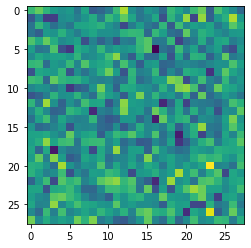

Streaming output truncated to the last 5000 lines.
Rec Loss:  65.28677368164062
Epoch: 9 batch: 803
Loss:  62.770076751708984
Acc:  0.71875
Rec Loss:  65.62541198730469
Epoch: 9 batch: 804
Loss:  62.713741302490234
Acc:  0.765625
Rec Loss:  65.13421630859375
Epoch: 9 batch: 805
Loss:  62.87335968017578
Acc:  0.71875
Rec Loss:  65.15708923339844
Epoch: 9 batch: 806
Loss:  62.81862258911133
Acc:  0.71875
Rec Loss:  64.97842407226562
Epoch: 9 batch: 807
Loss:  63.03290939331055
Acc:  0.65625
Rec Loss:  64.17366790771484
Epoch: 9 batch: 808
Loss:  62.99043273925781
Acc:  0.59375
Rec Loss:  62.79481506347656
Epoch: 9 batch: 809
Loss:  62.79573059082031
Acc:  0.734375
Rec Loss:  64.15840148925781
Epoch: 9 batch: 810
Loss:  62.75536346435547
Acc:  0.828125
Rec Loss:  65.58934020996094
Epoch: 9 batch: 811
Loss:  62.9025993347168
Acc:  0.65625
Rec Loss:  65.60163879394531
Epoch: 9 batch: 812
Loss:  62.71662521362305
Acc:  0.625
Rec Loss:  67.88910675048828
Epoch: 9 batch: 813
Loss:  62.75228500

In [ ]:
lr = 0.005
n_inference_steps_train = 100
inference_learning_rate =0.01
weight_learning_rate = 0.005
use_backwards_weights= False
use_backwards_nonlinearities=True
use_error_weights=True
n_epochs = 10000
l1 = UpDownLayer(784,300,64,lr,tanh,tanh_deriv,device=DEVICE)
l2 = UpDownLayer(300,100,64,lr,tanh,tanh_deriv,device=DEVICE)
l3 = UpDownLayer(100,10,64,lr,tanh,linear_deriv,device=DEVICE)
layers =[l1,l2,l3]
net = PCNet(layers,n_inference_steps_train,inference_learning_rate,weight_learning_rate,device=DEVICE)
#net.train([dataset[0]],n_epochs, n_inference_steps_train)
net.train(dataset[0:-2],n_epochs, n_inference_steps_train)
# only works moderately, I think the interferencei s just too bad? perhaps there is some way to interleave correctly?